## Character Image Recognition - Double English

Uses handwritten english data and typed data with different fonts

In [1]:
print("start")

start


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory

import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split

In [3]:
dir_path = "/kaggle/input/english-fontnumber-recognition/Font/Font"

validation_frac = 0.2
batch_size = 256
image_shape = [128, 128]
inverse = False

ds_train = image_dataset_from_directory(
    dir_path,
    labels='inferred',
    label_mode = 'categorical',
    image_size=image_shape,
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=True,
    subset="training",
    validation_split=validation_frac,
    seed=0
)

ds_valid = image_dataset_from_directory(
    dir_path,
    labels='inferred',
    label_mode = 'categorical',
    image_size=image_shape,
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=True,
    subset="validation",
    validation_split=validation_frac,
    seed=0
)

# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    image = tf.image.rgb_to_grayscale(image)
    if inverse:
        image = 1 - image
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

ds_valid = (
    ds_valid
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

Found 62992 files belonging to 62 classes.
Using 50394 files for training.
Found 62992 files belonging to 62 classes.
Using 12598 files for validation.


In [4]:
# # Initialize lists to hold the data
# X_train = []
# y_train = []

# # Iterate through the dataset
# for image_batch, label_batch in ds_train.as_numpy_iterator():
#     X_train.append(image_batch)
#     y_train.append(label_batch)

# # Convert lists to NumPy arrays
# X_train = np.concatenate(X_train, axis=0)
# y_train = np.concatenate(y_train, axis=0)
# y_train = np.argmax(y_train, axis=1)

# print(X_train.shape, y_train.shape)



In [5]:
# # Initialize lists to hold the data
# X_val = []
# y_val = []

# # Iterate through the dataset
# for image_batch, label_batch in ds_valid.as_numpy_iterator():
#     X_val.append(image_batch)
#     y_val.append(label_batch)

# # Convert lists to NumPy arrays
# X_val = np.concatenate(X_val, axis=0)
# y_val = np.concatenate(y_val, axis=0)
# y_val = np.argmax(y_val, axis=1)

# print(X_val.shape, y_val.shape)

In [6]:
def one_hot_encode(y):
    return keras.utils.to_categorical(y, num_classes=62)

In [7]:
from tensorflow.keras.preprocessing import image

def load_and_preprocess_image(img_path, target_size=image_shape, inverse=False, grayscale=False):
    """
    Load an image and make it a numpy array.
    """
    # Load the image
    img = image.load_img(img_path, target_size=target_size)
    
    # Convert to an array
    img_array = image.img_to_array(img)

    if grayscale:
        # Convert RGB to Grayscale
        img_array = tf.image.rgb_to_grayscale(img_array)

    # normalize to [0, 1]
    img_array = img_array / np.max(img_array)

    if inverse:
        img_array = 1 - img_array
    
    # Add a batch dimension (because the model expects a batch of images)
    img_array = np.expand_dims(img_array, axis=0)
    
    return img_array

In [8]:
def load_and_preprocess_images_from_dir(dir_path, target_size=image_shape, inverse=False, grayscale=False):
    X = []
    for img in sorted(os.listdir(dir_path)):
        img_path = os.path.join(dir_path, img)
        if not os.path.isfile(img_path):
            continue
            
        img_array = load_and_preprocess_image(img_path, target_size=target_size, inverse=inverse, grayscale=grayscale)
        img_array = np.squeeze(img_array, axis=0)
        X.append(img_array)

    X = np.array(X)
    return X

In [9]:
def load_and_preprocess_all_image_classes_from_dir(dir_path, target_size=image_shape, inverse=False, grayscale=False):
    X = []
    y = []
    for img in sorted(os.listdir(dir_path)):
        img_path = os.path.join(dir_path, img)
        if not os.path.isfile(img_path):
            continue

        i = int(img[3:6]) - 1 # index starts at 0
        
        img_array = load_and_preprocess_image(img_path, target_size=target_size, inverse=inverse, grayscale=grayscale)
        img_array = np.squeeze(img_array, axis=0)
        X.append(img_array)
        y.append(i)

    X = np.array(X)
    y = np.array(y)
    return X, y

In [10]:
dir2_path = "/kaggle/input/english-handwritten-characters-dataset/Img"
X2, y2 = load_and_preprocess_all_image_classes_from_dir(dir2_path, target_size=image_shape)
y2 = one_hot_encode(y2).astype(np.float32)

X2_train, X2_val, y2_train, y2_val = train_test_split(X2, y2)

ds2_train = tf.data.Dataset.from_tensor_slices((X2_train, y2_train))
ds2_train = (
    ds2_train
    .shuffle(buffer_size=len(X2_train))  # Shuffle the dataset
    .batch(batch_size) 
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

ds2_valid = tf.data.Dataset.from_tensor_slices((X2_val, y2_val))
ds2_valid = (
    ds2_valid
    .shuffle(buffer_size=len(X2_val))  # Shuffle the dataset
    .batch(batch_size) 
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

ds_train = ds_train.concatenate(ds2_train)
ds_valid = ds_valid.concatenate(ds2_valid)

ds_train = ds_train.shuffle(buffer_size=10000)
ds_valid = ds_valid.shuffle(buffer_size=10000)

In [11]:
# free memory
del X2_train
del y2_train
del X2_val
del y2_val

print(ds_valid.element_spec)
print(ds2_valid.element_spec)

(TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 62), dtype=tf.float32, name=None))
(TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 62), dtype=tf.float32, name=None))


In [12]:
model = keras.Sequential([
    layers.InputLayer(shape=image_shape + [1]),
    
    # Data Augmentation
    layers.RandomContrast(factor=0.1),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomZoom(height_factor=0.1, width_factor=0.1),

    # Block One
    layers.BatchNormalization(),
    layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same', kernel_regularizer='l2'),
    layers.MaxPool2D(),

    # Block Two
    layers.BatchNormalization(),
    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same', kernel_regularizer='l2'),
    layers.MaxPool2D(),

    # Block Three
    layers.BatchNormalization(),
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    layers.GlobalAveragePooling2D(),

    # Head
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu', kernel_regularizer='l2'),
    layers.Dense(62, activation='softmax'),
])

In [13]:
from tensorflow.keras.callbacks import EarlyStopping
import shutil

train_model = True

weights_path = "/kaggle/input/char-recognition-model-double-english/keras/default/1/char_recog_model_double_english.weights.h5"
if os.path.isfile(weights_path) and not train_model:
    model.load_weights(weights_path)
    history = None

else:
    early_stopping = EarlyStopping(min_delta=0.001, patience=20, restore_best_weights=True)
    
    optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-5)
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy'],
    )
    
    history = model.fit(
        ds_train,
        validation_data=ds_valid,
        epochs=250,
        callbacks=[early_stopping]
    )

    model.save_weights("char_recog_model.weights.h5")
    shutil.move("char_recog_model.weights.h5", "/kaggle/working/char_recog_model.weights.h5")

Epoch 1/250
207/207 ━━━━━━━━━━━━━━━━━━━━ 156s 388ms/step - accuracy: 0.2351 - loss: 4.8552 - val_accuracy: 0.0157 - val_loss: 7.0005
Epoch 2/250
207/207 ━━━━━━━━━━━━━━━━━━━━ 53s 258ms/step - accuracy: 0.7031 - loss: 1.5953 - val_accuracy: 0.0178 - val_loss: 8.8257
Epoch 3/250
207/207 ━━━━━━━━━━━━━━━━━━━━ 53s 258ms/step - accuracy: 0.7767 - loss: 1.0462 - val_accuracy: 0.3136 - val_loss: 2.9323
Epoch 4/250
207/207 ━━━━━━━━━━━━━━━━━━━━ 53s 258ms/step - accuracy: 0.7899 - loss: 0.8947 - val_accuracy: 0.7508 - val_loss: 1.0114
Epoch 5/250
207/207 ━━━━━━━━━━━━━━━━━━━━ 53s 258ms/step - accuracy: 0.8035 - loss: 0.8123 - val_accuracy: 0.7732 - val_loss: 0.9225
Epoch 6/250
207/207 ━━━━━━━━━━━━━━━━━━━━ 53s 258ms/step - accuracy: 0.8107 - loss: 0.7542 - val_accuracy: 0.5286 - val_loss: 1.7783
Epoch 7/250
207/207 ━━━━━━━━━━━━━━━━━━━━ 53s 258ms/step - accuracy: 0.8156 - loss: 0.7185 - val_accuracy: 0.7509 - val_loss: 0.9456
Epoch 8/250
207/207 ━━━━━━━━━━━━━━━━━━━━ 53s 258ms/step - accuracy: 0.8192 

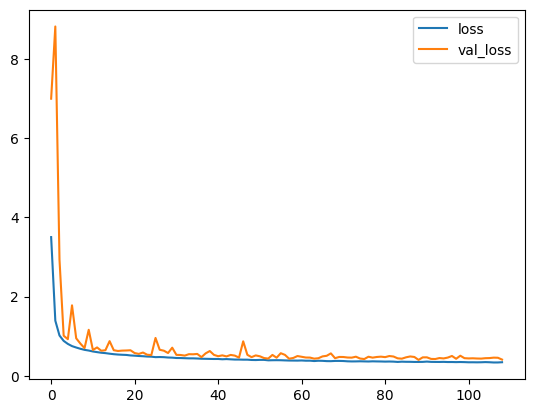

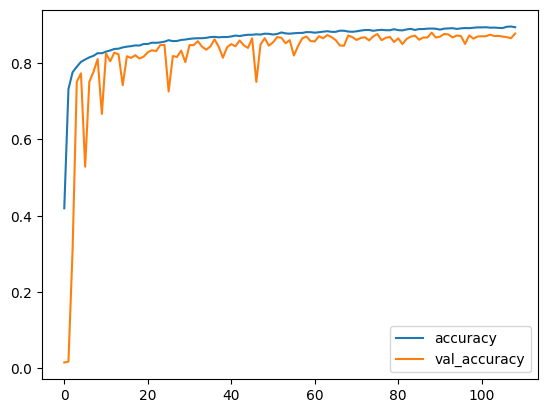

In [14]:
import pandas as pd
if history is not None:
    history_frame = pd.DataFrame(history.history)
    history_frame.loc[:, ['loss', 'val_loss']].plot()
    history_frame.loc[:, ['accuracy', 'val_accuracy']].plot()

In [15]:
def plot_n_images(X, y, n=10, row_spacing=0.5):
    plt.figure(figsize=(10, 5))
    # Show the first n images if available, otherwise show all images
    for i in range(min(n, X.shape[0], y.shape[0])):  
        plt.subplot(n // 5 + 1, 5, i+1)
        plt.imshow(X[i], cmap='gray')  # Assuming 28x28 images
        plt.title(label_map[y[i]])
        plt.axis('off')

    plt.subplots_adjust(hspace=row_spacing)
    plt.show()

### Validation data same dataset accuracy

In [16]:
from sklearn.metrics import accuracy_score

if history is not None:
    loss, accuracy = model.evaluate(ds_valid)
    print(loss, accuracy)

54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.8767 - loss: 0.4210
0.39963608980178833 0.8797858953475952


In [17]:
from string import ascii_lowercase, ascii_uppercase
alphabet_plus = "0123456789" + ascii_uppercase + ascii_lowercase
label_map = {i: alphabet_plus[i] for i in range(len(alphabet_plus))}


In [18]:
dir_path = "/kaggle/input/letters-and-digits/Images characters/"

dir_path_handwritten_upper = "/kaggle/input/letters-and-digits/Images characters/Handwritten/Uppercase"
dir_path_handwritten_lower = "/kaggle/input/letters-and-digits/Images characters/Handwritten/Lowercase"
dir_path_handwritten_math = "/kaggle/input/letters-and-digits/Images characters/Handwritten/Math"

dir_path_typed_upper = "/kaggle/input/letters-and-digits/Images characters/Typed/Uppercase"
dir_path_typed_lower = "/kaggle/input/letters-and-digits/Images characters/Typed/Lowercase"

img_path_zero = "/kaggle/input/letters-and-digits/Images characters/zero.png"
img_path_drawn_zero = "/kaggle/input/letters-and-digits/Images characters/drawn_zero.png"
img_path_drawn_M_close = "/kaggle/input/letters-and-digits/Images characters/M_handwritten_close.png"
img_path_drawn_M_far = "/kaggle/input/letters-and-digits/Images characters/M_handwritten_far.png"

(17, 128, 128, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
(17, 128, 128, 1) (17,)


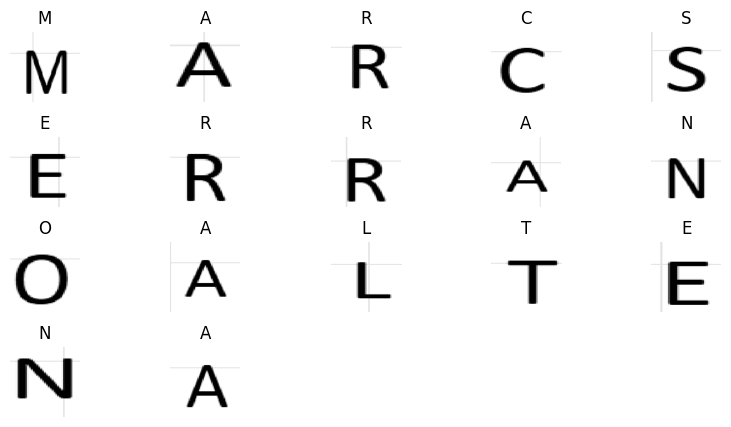

In [23]:
path = dir_path_typed_upper
processed_images = load_and_preprocess_images_from_dir(path, target_size=(128, 128), grayscale=True, inverse=inverse)
# processed_image = np.array([X_test[2]])

print(processed_images.shape)

# Make the prediction
predictions = model.predict(processed_images)

# For multi-class classification (e.g., 62 classes):
# Get the index of the class with the highest probability
predicted_classes = np.argmax(predictions, axis=1)

print(processed_images.shape, predicted_classes.shape)
plot_n_images(processed_images, predicted_classes, n=17, row_spacing=0.5)

### EMNIST data accuracy